Author: Lewen Sun, Hao Zhang, Frank Liu

# **Topic: Amazon Product Co-purchasing Network**

Import required libraries

In [1]:
!pip install stemming

  Preparing metadata (setup.py) ... done
  Created wheel for stemming: filename=stemming-1.0.1-py3-none-any.whl size=11123 sha256=be039beeb99df164f4f3d6341861a7bed91349eccfa8d20e4718157813797b3c
  Stored in directory: /root/.cache/pip/wheels/c5/f9/3f/8fe1ec182ce66145d7ded39bad9a690960469dc350fbec0181
Successfully built stemming


In [2]:
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import string
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from stemming.porter2 import stem
import networkx
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pylab as plt
from IPython.display import Image
from community import community_louvain
from collections import Counter
from itertools import chain
#pyo.init_notebook_mode()
import plotly.io as pio
pio.renderers.default = 'browser'

In [4]:
# read Amazon Product Metadata
df = open ('/content/drive/MyDrive/amazon-meta.txt', 'r', encoding='utf-8', errors= 'ignore')

Data preprocessing:

In [5]:
amazonProducts= {}
import nltk
nltk.download('stopwords')
# fill the amazonProducts dictionary
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)

for line in df:
    line = line.strip()
    if(line.startswith("Id")): # a product block started
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        ls = line.split()
        Copurchased = ' '.join([c for c in ls[2:]])
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((df.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ',Categories)
        Categories = ' '.join(set(Categories.split())-set(stopwords.words("english")))
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip() # a product block ended
    elif (line==""): # write out fields to amazonProducts dictionary
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProducts[ASIN] = MetaData
            MetaData['Id'] = Id
            MetaData['Title'] = Title
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['Copurchased'] = Copurchased
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['DegreeCentrality'] = DegreeCentrality
            MetaData['ClusteringCoeff'] = ClusteringCoeff
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)
df.close

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<function TextIOWrapper.close()>

In [6]:
#create Music specific dictionary exclusively for Musics
amazonMusics = {}
for asin,metadata in amazonProducts.items():
    if (metadata['Group']=='Music'):
        amazonMusics[asin]=amazonProducts[asin]

#remove items that we don't have metadata associated with it
for asin, metadata in amazonMusics.items():
    amazonMusics[asin]['Copurchased']= ' '.join([cp for cp in metadata['Copurchased'].split() if cp in amazonMusics.keys()])

In [7]:
#create a product copurchase graph for analysis(nodes are product ASINs, the graph edge are copurchased relationships, and edge weight is similarity between ASINs based on category)

copurchaseGraph = networkx.Graph()
for asin, metadata in amazonMusics.items():
    copurchaseGraph.add_node(asin)
    for a in metadata ['Copurchased'].split():
        copurchaseGraph.add_node(a.strip())
        similarity= 0
        n1= set((amazonMusics[asin]['Categories']).split())
        n2= set ((amazonMusics[a]['Categories']).split())
        n1In2 = n1 & n2
        n1Un2 = n1 | n2
        if (len(n1Un2)) > 0:
            similarity = round (len(n1In2)/len(n1Un2), 2)
        copurchaseGraph.add_edge(asin, a.strip(), weight = similarity)

In [8]:
# Get degree centrality and clustering coefficients
dc = networkx.degree(copurchaseGraph)
for asin in networkx.nodes(copurchaseGraph):
    metadata = amazonMusics[asin]
    metadata['DegreeCentrality'] = int(dc[asin])
    ego = networkx.ego_graph(copurchaseGraph, asin, radius = 1)
    metadata['ClusteringCoeff'] = round(networkx.average_clustering(ego), 2)
    amazonMusics[asin] = metadata

In [9]:
# Write amazonMusics data to amazon-Musics.txt
df1 = open('./amazon-Musics.txt', 'w', encoding = 'utf-8', errors = 'ignore')
df1.write('Id\t' + 'ASIN\t' + 'Title\t'+
         'Categories\t' + 'Group\t' + 'Copurchased\t'+
         'SalesRank\t' + 'TotalReviews\t' + 'AvgRating\t'+
         'DegreeCentrality\t' + 'ClusteringCoeff\n')
for asin, metadata in amazonMusics.items():
    df1.write(metadata['Id'] + '\t' +
              asin + '\t' +
              metadata['Title'] + '\t' +
              metadata['Categories'] + '\t' +
              metadata['Group'] + '\t' +
              metadata['Copurchased'] +'\t' +
              str(metadata['SalesRank']) + '\t' +
              str(metadata['TotalReviews']) + '\t' +
              str(metadata['AvgRating']) + '\t' +
              str(metadata['DegreeCentrality']) + '\t' +
              str(metadata['ClusteringCoeff']) + '\n')
df1.close()

# Write amazon-Musics-copurchase.edgelist which single nodes are not contained
df1 = open('amazon-Musics-copurchase.edgelist', 'wb')
networkx.write_weighted_edgelist(copurchaseGraph, df1)
df1.close()

Graph analysis and Visualization:

In [10]:
df2= open('amazon-Musics-copurchase.edgelist')
copurchaseGraph = nx.read_weighted_edgelist(df2)
df2.close()

In [11]:
import plotly.graph_objects as go

def degree_rank(net):
    degree_sequence = sorted((d for n, d in net.degree()), reverse=True)
    df = pd.DataFrame(degree_sequence, columns=['Degree'])
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=df['Degree']))
    fig.update_layout(xaxis_title="Rank")
    fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    })
    fig.show(renderer="colab")

degree_rank(copurchaseGraph)


In [12]:
import plotly.graph_objects as go

def degree_hist(net, kind=None, group=False):
    if kind == 'in':
        degrees = dict(net.in_degree())
    elif kind == 'out':
        degrees = dict(net.out_degree())
    else:
        degrees = dict(net.degree())

    fig = go.Figure(data=[go.Histogram(x=list(degrees.values()))])
    fig.update_layout(xaxis_title="Degree", yaxis_title="# of Nodes", bargap=0.01)
    fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    })
    fig.show(renderer="colab")

degree_hist(copurchaseGraph)

In [13]:
# Check connection
nx.is_connected(copurchaseGraph)

False

In [14]:
# Average degree
sum(dict(copurchaseGraph.degree()).values()) / nx.number_of_nodes(copurchaseGraph)

4.782275977236985

In [15]:
# Number of connected components
nx.number_connected_components(copurchaseGraph)

1838

In [16]:
# Average clustering coefficient
nx.average_clustering(copurchaseGraph)

0.4391237823466259

In [17]:
# Density of the graph
nx.density(copurchaseGraph)

7.753617136153871e-05

<ipython-input-18-7e71b7032336>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-18-7e71b7032336>:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



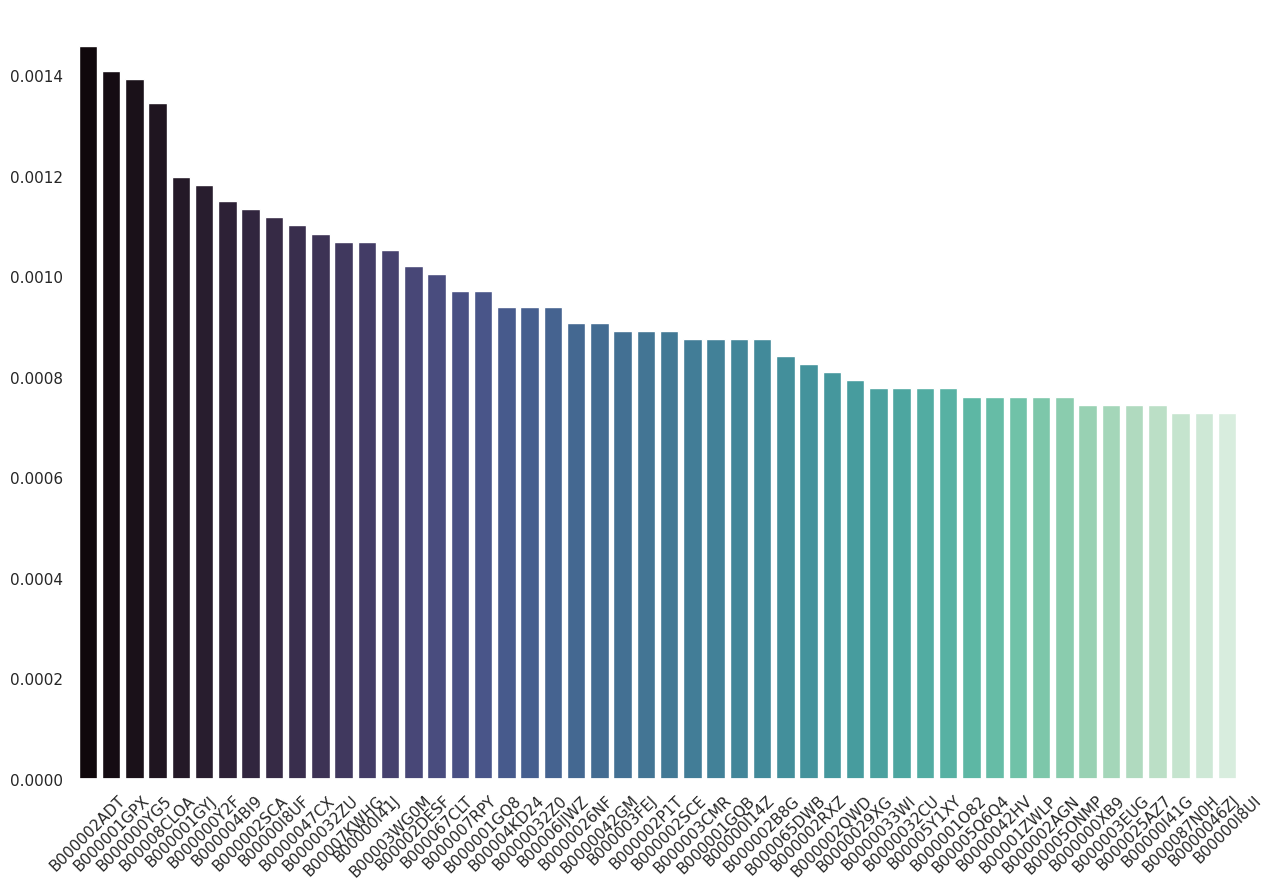

In [18]:
#creates a bar plot visualizing the degree centrality of the top 50 nodes in a network graph based on their ASIN identifiers.
deg_cen_g_copurchase = nx.degree_centrality(copurchaseGraph)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[0:50]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]
degree = [j for i,j in sorted_deg_cen_g_copurchase]
custom_palette1 = sns.color_palette("mako", 50)
custom_palette2 = sns.color_palette("light:b", 50)
custom_palette2.reverse()
sns.set(rc={'figure.figsize':(15,10), 'axes.facecolor':'white'})
ax = sns.barplot(x = ASIN, y = degree, palette = custom_palette1)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

In [19]:
mean_weights = []
for j in ASIN:
    neigh = copurchaseGraph.edges(j, data= True)
    weight = []
    for i in neigh:
        weight.append(i[2]['weight'])
    weight
    mean_weights.append(np.mean(weight))
mean_weights
print('Mean of similarity between most connected nodes: ', np.mean(mean_weights))

Mean of similarity between most connected nodes:  0.47080931555264477


In [20]:
l = list(copurchaseGraph.edges(data= True))
total_weights = []
for i in l:
    total_weights.append(i[2]['weight'])
total_mean_weights = np.mean(total_weights)
print('Mean of similarity between all nodes: ', total_mean_weights)

Mean of similarity between all nodes:  0.6070153170195887


Sample analysis

In [21]:
df2 = open('amazon-Musics-copurchase.edgelist', 'r')
data = nx.read_weighted_edgelist(df2)
df2.close()
c = list(data.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []
deg_cen_g_copurchase = nx.degree_centrality(data)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[0:50]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges = {'Source': fr, 'Target': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df = pd.DataFrame(edges)
df.to_csv('Highest degree centrality nodes.csv', index = False)

In [22]:
sample = pd.read_csv('Highest degree centrality nodes.csv')
sample = pd.DataFrame(sample)
g = nx.from_pandas_edgelist(sample, 'Source', 'Target', ['Weight'])

In [23]:
# Check connection
nx.is_connected(g)

False

In [24]:
# Average degree
sum(dict(g.degree()).values()) / nx.number_of_nodes(g)

2.3411214953271027

In [25]:
# Number of connected components
nx.number_connected_components(g)

14

In [26]:
# Clustering coefficient of all nodes (in a dictionary)
nx.clustering(g)

{'B00008CLOA': 0,
 'B000006TRV': 0,
 'B00005HYH5': 0,
 'B00005QK3Y': 0,
 'B00005MK6X': 0,
 'B00004S875': 0,
 'B00008NGHI': 0,
 'B000007SIN': 0,
 'B000002G3U': 0,
 'B000002G3V': 0,
 'B00005RTL7': 0,
 'B00008WT49': 0,
 'B00006FN7P': 0,
 'B00005O12R': 0,
 'B00005B6BY': 0,
 'B00004W5A6': 0,
 'B00004W5AF': 0,
 'B00004TY08': 0,
 'B00004YR52': 0,
 'B00004T0DN': 0,
 'B00004W5A2': 0,
 'B000088NSZ': 0,
 'B00004T1EE': 0,
 'B00005QZLD': 0,
 'B00005QZL7': 0,
 'B00006GO7T': 0,
 'B00006L6YG': 0,
 'B00004NHBI': 0,
 'B00004NKFE': 0,
 'B00005QDW5': 0,
 'B00004I9VE': 0,
 'B00004WIRG': 0,
 'B000003CSG': 0,
 'B000024D4S': 0,
 'B000024D4R': 0,
 'B00006B1NN': 0,
 'B00006L6YI': 0,
 'B00005A15L': 0,
 'B000044U19': 0,
 'B00007E8SW': 0,
 'B00005OAIB': 0,
 'B00005OAIF': 0,
 'B00004OCXO': 0,
 'B00003WGO1': 0,
 'B00006310E': 0,
 'B00000K4IM': 0,
 'B00005MJXR': 0,
 'B00005RGNH': 0,
 'B00004UEJS': 0,
 'B00005B5L4': 0,
 'B00004YC2X': 0,
 'B0000025RI': 0,
 'B0000025RJ': 0,
 'B00004KD6V': 0,
 'B000002IWM': 0,
 'B00005TN

In [27]:
# Average clustering coefficient
nx.average_clustering(g)

0.12065950543654308

In [28]:
# The density tells us how many of the possible edges in the graph are actually present:
nx.density(g)

0.0010944934527008427

In [29]:
centr = nx.betweenness_centrality(g)
centr_df = pd.DataFrame(centr.items(), columns = ['Node', 'Betweeness'])
centr_df

,Node,Betweeness
0,B00008CLOA,0.184642
1,B000006TRV,0.000000
2,B00005HYH5,0.000000
3,B00005QK3Y,0.000000
4,B00005MK6X,0.000000
...,...,...
2135,B000002B8M,0.000000
2136,B000002B8J,0.000000
2137,B000002B8O,0.000000
2138,B000002BF1,0.000000


Network Visulization:

In [30]:
plt.rcParams.update(plt.rcParamsDefault)
pos = nx.spring_layout(g, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    g,
    pos=pos,
    node_size=0,
    edge_color="#444444",
    alpha=0.06,
    with_labels=False)

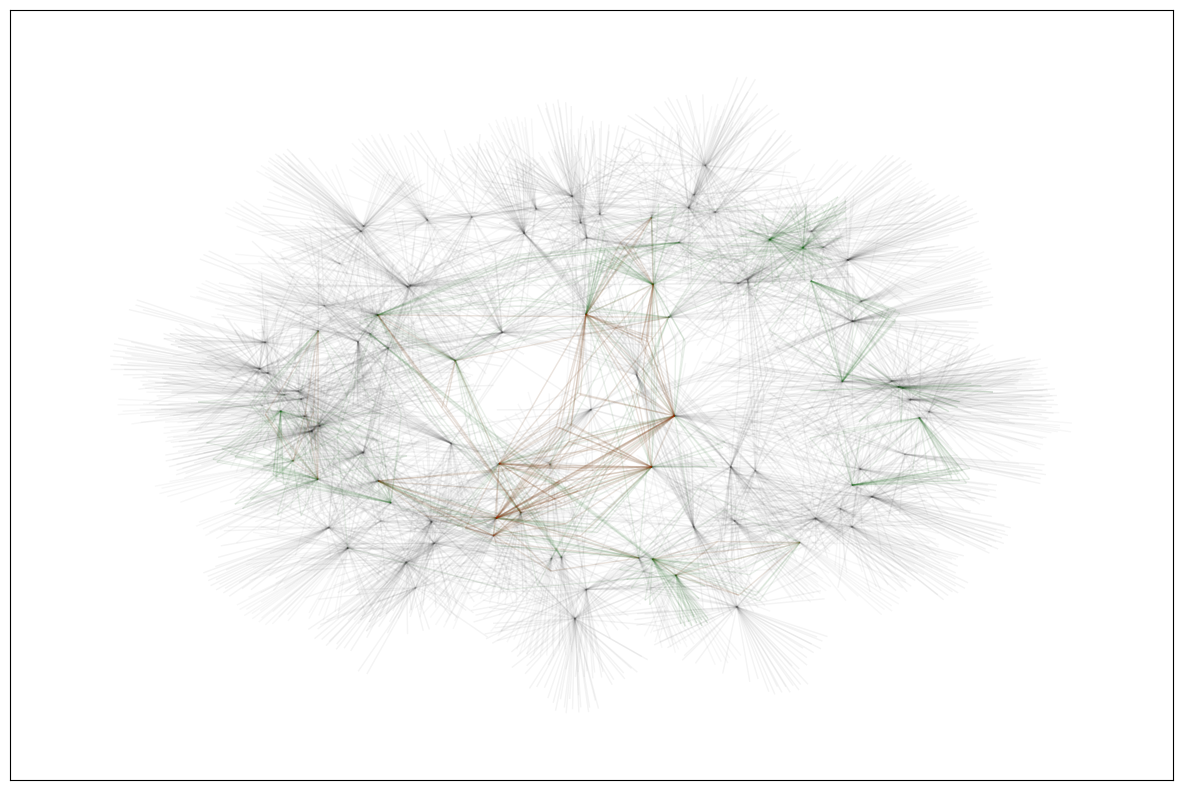

In [31]:
# Cores with at lest degree 2
G_core_2 = nx.k_core(g, 2)
# Similarly, with at least degree 3
G_core_3 = nx.k_core(g, 3)
# Visualize network and k-cores
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(g, k=0.1)
nx.draw_networkx(
    g, pos=pos, node_size=0, edge_color="#333333", alpha=0.04, with_labels=False)
nx.draw_networkx(
    G_core_2, pos=pos, node_size=0, edge_color="green", alpha=0.05, with_labels=False)
nx.draw_networkx(
    G_core_3, pos=pos, node_size=0, edge_color="red", alpha=0.05, with_labels=False)
plt.show()

In [32]:
# Adjcency matrix for first 50 sorted nodes
# Reduce the dataset to the 50 nodes with highest degree centrality and their neighbors
deg_cen_g_copurchase = nx.degree_centrality(copurchaseGraph)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[0:50]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]
c = list(copurchaseGraph.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges = {'From Node': fr, 'To Node': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df1 = pd.DataFrame(edges)
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')

# Adjcency matrix for first 50 sorted nodes
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
adj = nx.adjacency_matrix(G, weight='Weight')
print(adj.shape)
plt.spy(adj)

(2140, 2140)


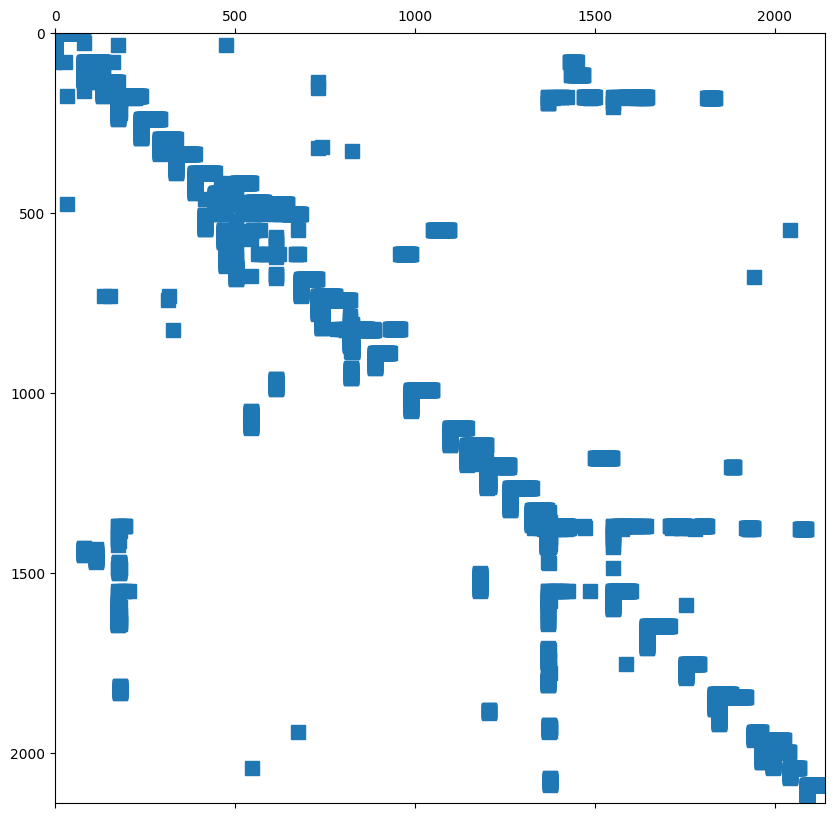

In [33]:
# TOP 50
plt.show()

In [34]:
deg_cen_g_copurchase = nx.degree_centrality(copurchaseGraph)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[50:100]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]
c = list(copurchaseGraph.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges = {'From Node': fr, 'To Node': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df1 = pd.DataFrame(edges)
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')

# Adjcency matrix for sorted nodes from 100 to 250
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
adj1 = nx.adjacency_matrix(G, weight='Weight')
print(adj1.shape)
plt.spy(adj1)


(1579, 1579)


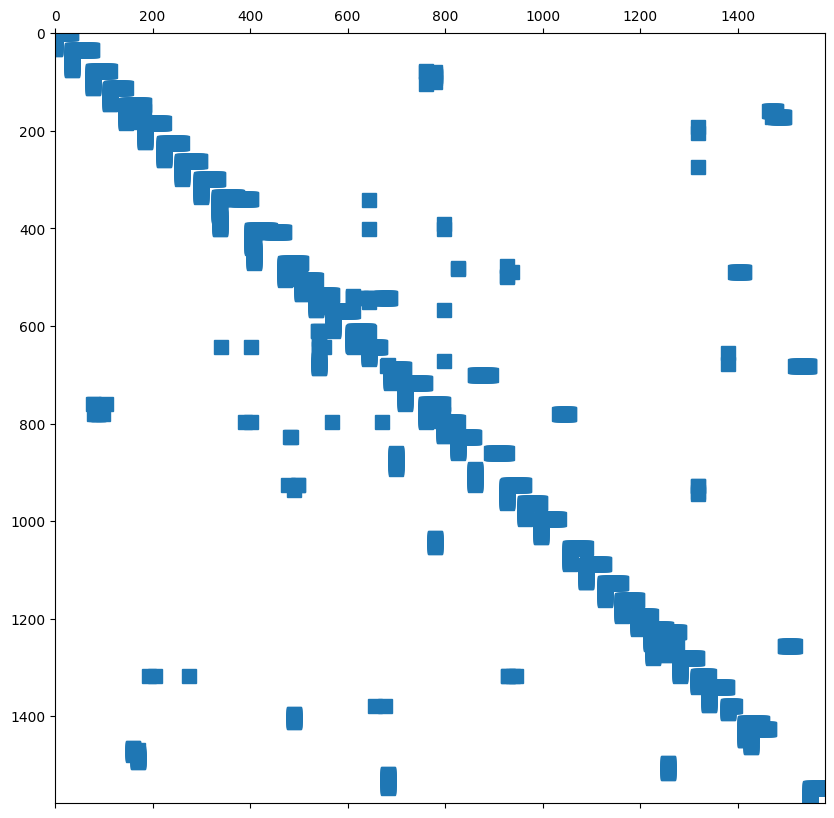

In [35]:
# TOP 50-100
plt.show()

In [36]:
deg_cen_g_copurchase = nx.degree_centrality(copurchaseGraph)
sorted_deg_cen_g_copurchase = sorted(deg_cen_g_copurchase.items(), key=lambda x:x[1], reverse = True)[100:150]
ASIN = [i for i,j in sorted_deg_cen_g_copurchase]
c = list(copurchaseGraph.edges(data = True))
fr = []
to = []
weight = []
deg_cen = []

for i in c:
    if i[0] in ASIN:
        fr.append(i[0])
        to.append(i[1])
        weight.append(i[2]['weight'])
        deg_cen.append(dict(sorted_deg_cen_g_copurchase)[i[0]])

edges = {'From Node': fr, 'To Node': to, 'Weight' : weight, 'Degree Centrality': deg_cen}
df1 = pd.DataFrame(edges)
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
# Adjcency matrix for sorted nodes from 260 to 450
G = nx.from_pandas_edgelist(df1, source = 'From Node', target = 'To Node', edge_attr = 'Weight')
adj2 = nx.adjacency_matrix(G, weight='Weight')
print(adj2.shape)
plt.spy(adj2)

(1328, 1328)


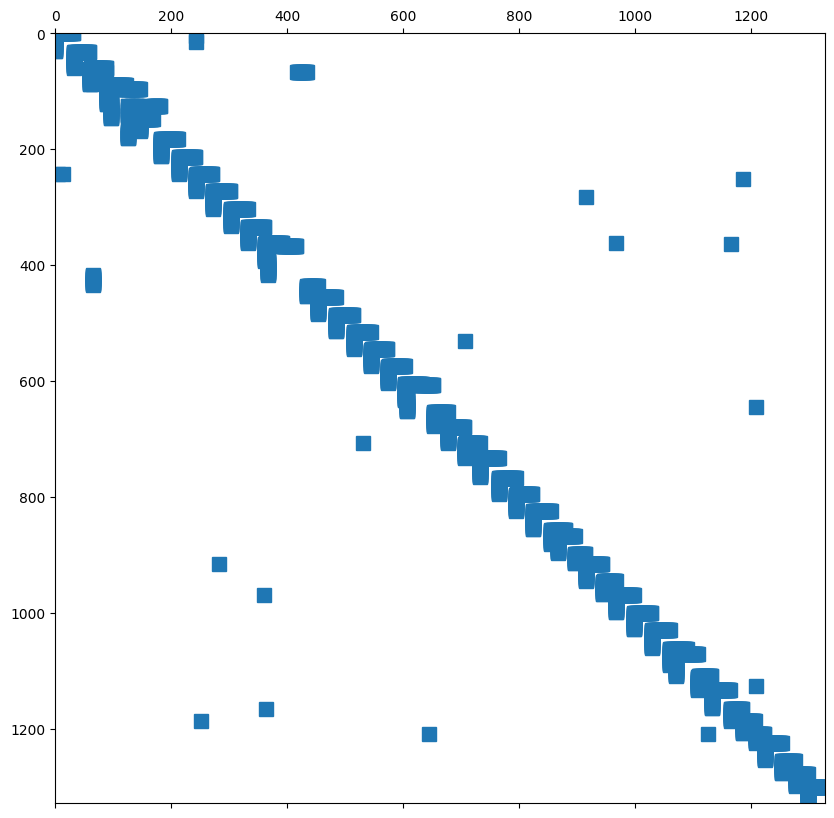

In [37]:
# TOP 100-150
plt.show()

Recommendation system:

In [38]:
import networkx
from operator import itemgetter
import matplotlib.pyplot

df = open ('/content/amazon-Musics.txt', 'r', encoding='utf-8', errors= 'ignore')
amazonMusics= {}


In [39]:
df.readline()
for line in df:
    cell = line.split ('\t')
    MetaData = {}
    MetaData['Id'] = cell[0].strip()
    ASIN = cell[1].strip()
    MetaData['Title'] = cell[2].strip()
    MetaData['Categories'] = cell[3].strip()
    MetaData['Group'] = cell[4].strip()
    MetaData['Copurchased'] = cell[5].strip()
    MetaData['SalesRank'] = int(cell[6].strip())
    MetaData['TotalReviews'] = int(cell[7].strip())
    MetaData['AvgRating']= float(cell[8].strip())
    MetaData['DegreeCentrality']= int(cell[9].strip())
    MetaData['ClusteringCoeff'] = float(cell[10].strip())
    amazonMusics[ASIN] = MetaData
df.close()


In [40]:
print('looking for RS for customer purchasing this book:')
print('....')
purchasedAsin = 'B000002ADT'
print ('ASIN = ', purchasedAsin)
print('Title = ', amazonMusics[purchasedAsin]['Title'])
print('SalesRank = ', amazonMusics[purchasedAsin]['SalesRank'])
print('TotalReviews = ', amazonMusics[purchasedAsin]['TotalReviews'])
print('AvgRating = ', amazonMusics[purchasedAsin]['AvgRating'])
print('DegreeCentrality = ', amazonMusics[purchasedAsin]['DegreeCentrality'])
print('ClusteringCoeff = ', amazonMusics[purchasedAsin]['ClusteringCoeff'])


looking for RS for customer purchasing this book:
....
ASIN =  B000002ADT
Title =  Kind of Blue
SalesRank =  117
TotalReviews =  541
AvgRating =  5.0
DegreeCentrality =  90
ClusteringCoeff =  0.59


In [41]:
copurchaseGraph = networkx.Graph()
for asin, metadata in amazonMusics.items():
    copurchaseGraph.add_node(asin)
    for a in metadata ['Copurchased'].split():
        copurchaseGraph.add_node(a.strip())
        similarity=0
        n1= set((amazonMusics[asin]['Categories']).split())
        n2= set ((amazonMusics[a]['Categories']).split())
        n1In2 = n1 & n2
        n1Un2 = n1 | n2
        if (len(n1Un2)) > 0:
            similarity = round (len(n1In2)/len(n1Un2), 2)
        copurchaseGraph.add_edge(asin, a.strip(), weight=similarity)

In [42]:
node = 'B000002ADT'  # the target node
neighbors = list(copurchaseGraph.neighbors(node))
print("Neighbors of node", node, ":", neighbors)

Neighbors of node B000002ADT : ['B0000047FT', 'B000003D43', 'B000003489', 'B0000047CX', 'B000002I4S', 'B000046PVI', 'B0000572E8', 'B000002AGN', 'B00004S873', 'B00003XAQ6', 'B000002I53', 'B0000046ZH', 'B000005H2J', 'B00004S3AN', 'B000002AA0', 'B000027826', 'B00000IMYA', 'B000000Y2F', 'B000000YX9', 'B000003N98', 'B000056CAN', 'B000002699', 'B0000062F9', 'B000005H4W', 'B00006GO7T', 'B0000041Y0', 'B00006L6YG', 'B00005B58V', 'B00005B58W', 'B00005B58Y', 'B000005H7D', 'B000000Y1B', 'B0000931PO', 'B000002BE1', 'B00005MIZ4', 'B00004SGNP', 'B00000I14Z', 'B00006GO9Q', 'B00006GO99', 'B00004STOV', 'B000005HBS', 'B00006K06N', 'B00000HYID', 'B00004XSX8', 'B000005HDZ', 'B00008NGAF', 'B00007E8SW', 'B000002XQU', 'B000005HEX', 'B000000YAL', 'B00000J7SS', 'B000002ALA', 'B000002AL8', 'B00000FC7M', 'B0000000V6', 'B00005614M', 'B0000046M1', 'B00000HZE2', 'B000005HGN', 'B000000YGI', 'B000000YG4', 'B000000Y87', 'B00004UEIF', 'B000069DWX', 'B000005H9I', 'B00005TOXQ', 'B000002AH7', 'B000002AH6', 'B00004R5WI', 'B

In [43]:
n=purchasedAsin
ego=networkx.ego_graph(copurchaseGraph, n, radius=1)
purchasedAsinEgoGraph = networkx.Graph(ego)

In [44]:
threshold = 0.5
purchasedAsinEgoTrimGraph = nx.Graph()
for f, t, e in purchasedAsinEgoGraph.edges(data=True):
    if e['weight'] >= threshold:
        purchasedAsinEgoTrimGraph.add_edge(f, t, **e)

purchasedAsinNeighbors = purchasedAsinEgoTrimGraph.neighbors(purchasedAsin)

In [45]:
asMeta = []
for asin in purchasedAsinNeighbors:
    ASIN = asin
    Title = amazonMusics[asin]['Title']
    SalesRank = amazonMusics[asin]['SalesRank']
    TotalReviews = amazonMusics[asin]['TotalReviews']
    AvgRatin = amazonMusics[asin]['AvgRating']
    DegreeCentrality = amazonMusics[asin]['DegreeCentrality']
    ClusteringCoeff = amazonMusics[asin]['ClusteringCoeff']
    asMeta.append((ASIN, Title, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff))

    t5 = sorted(asMeta, key = lambda x: (x[4], x[3]), reverse = True)[:4]

In [46]:
print()
print('top 5 recommendations')
print('...')
print(t5)

print('ASIN\t', 'Title\t', 'SalesRank\t', 'TotalReviews\t', 'Avgrating\t', 'DegreeCentrality\t', 'ClusteringCoeff')
for asin in t5:
    print(asin)
print()


top 5 recommendations
...
[('B000002AGN', 'Time Out', 415, 140, 0.0, 47, 0.55), ('B00004S3AN', 'Time Out', 8171, 140, 0.0, 5, 0.9), ('B000003N7F', 'A Love Supreme', 310677, 134, 0.0, 5, 0.9), ('B000003489', 'Giant Steps [Deluxe Edition]', 25612, 102, 0.0, 21, 0.41)]
ASIN	 Title	 SalesRank	 TotalReviews	 Avgrating	 DegreeCentrality	 ClusteringCoeff
('B000002AGN', 'Time Out', 415, 140, 0.0, 47, 0.55)
('B00004S3AN', 'Time Out', 8171, 140, 0.0, 5, 0.9)
('B000003N7F', 'A Love Supreme', 310677, 134, 0.0, 5, 0.9)
('B000003489', 'Giant Steps [Deluxe Edition]', 25612, 102, 0.0, 21, 0.41)

